In [16]:
import numpy as np
import pandas as pd
import os
import pandas_profiling
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, roc_curve
import glob
from scipy.stats import mannwhitneyu

In [17]:
def diversity_measures(frequency, counts):
    # Species Richness
    total_species = len(frequency)
    
    # Shannon diversity
    i=0
    log_frequency = []
    while i < len(frequency):
        a = np.log(frequency[i])
        i+=1
        log_frequency.append(a)
    H1 = -np.sum(frequency * log_frequency)

    # Simpson diversity index
    N = np.sum(frequency)
    n = frequency 
    squared_frequency=[]
    i=0
    while i < len(frequency):
        a = frequency[i]**2
        i+=1
        squared_frequency.append(a)
    simpson = sum(squared_frequency)

    # Berger-Park Index
    B = np.max(frequency)

    #Chao2 estimator
    f1 = 0
    f2 = 0
    for count in counts:
        if int(count) == 1:
            f1 += 1
        if int(count) == 2:
            f2 += 1
    Chao2_bias = total_species + f1*(f1-1)/(2*(f2+1))

    return total_species, H1, (1-simpson), B, Chao2_bias

In [18]:
## Cohort 1
# Read in Names of Files here
basefolder = ""
plotsfolder = 'plots'
namesfile = ""
metadata = pd.read_csv(os.path.join(basefolder, namesfile))
metadata = metadata[~metadata['Age'].isin(['Unknown', 'nk'])]
metadata['Age'] = [int(age) for age in metadata['Age']]
# exclude samples with unknown age
metadata_gDNA = metadata[metadata['gDNA']==1]

In [19]:
# GCA DATA
diversities = []
for name in metadata_gDNA[metadata_gDNA['GCA Status'] == 1]['Name']:
    if len(glob.glob(basefolder+'/cleaned data/*'+name+'*_cleaned.txt')) > 1: #check samples are unique
        print(name, glob.glob(basefolder+'/cleaned data/*'+name+'*_cleaned.txt'))
    for filename in glob.glob(basefolder+'/cleaned data/*'+name+'*_cleaned.txt'):
        sample = pd.read_csv(
            filename,
            usecols=['cloneCount', 'cloneFraction', 'aaSeqCDR3', 'bestVHit', 'bestJHit']
        )
        #sample = sample[sample['cloneFraction'] >= cutoff]

        total_species, H1, simpson, B, Chao2_bias = diversity_measures(sample['cloneFraction'], sample['cloneCount'])
        diversities.append([total_species, H1, simpson, B])
diversities = pd.DataFrame(diversities, columns = ['Species R.', 'Shannon', 'Simpson', 'Berger-Park'])
gca_data = pd.concat([metadata_gDNA[metadata_gDNA['GCA Status'] == 1].reset_index(), diversities], axis=1)

In [20]:
control_files = pd.read_csv(os.path.join(basefolder,'TCRs_for_clustering','agematched_control_files.csv'))

In [21]:
# AGEMATCHED CONTROL DATA
diversities = []
for name in control_files['Name']:
    if len(glob.glob(basefolder+'/cleaned data/*'+name+'*_cleaned.txt')) > 1: #check samples are unique
        print(basefolder+'/cleaned data/*'+name+'*_cleaned.txt', glob.glob(basefolder+'cleaned data/*'+name+'*_cleaned.txt'))
    for filename in glob.glob(basefolder+'/cleaned data/*'+name+'*_cleaned.txt'):
        sample = pd.read_csv(
            filename,
            usecols=['cloneCount', 'cloneFraction', 'aaSeqCDR3', 'bestVHit', 'bestJHit']
        )
        total_species, H1, simpson, B, Chao2_bias = diversity_measures(sample['cloneFraction'], sample['cloneCount'])
        diversities.append([total_species, H1, simpson, B])
diversities = pd.DataFrame(diversities, columns = ['Species R.', 'Shannon', 'Simpson', 'Berger-Park'])
control_data = pd.concat([metadata_gDNA[metadata_gDNA['Control Status'] == 1].reset_index(), diversities], axis=1).dropna()

In [22]:
significant_combinations = {}
for diversity in ['Species R.', 'Shannon', 'Simpson']:
    dist1 = gca_data[diversity].to_numpy()
    dist2 = control_data[diversity].to_numpy()
    U, p = mannwhitneyu(dist1, dist2, alternative='two-sided')
    if p < 0.05:
        significant_combinations[diversity] =  p
significant_combinations

{'Species R.': 0.00032603258487557096,
 'Shannon': 0.0036472072859125328,
 'Simpson': 0.04340024074645014}

In [23]:
gca_data['Label'] = ['GCA' for x in gca_data['Shannon']]
control_data['Label'] = ['Age-matched Control' for x in control_data['Shannon']]
data=pd.concat([gca_data, control_data])

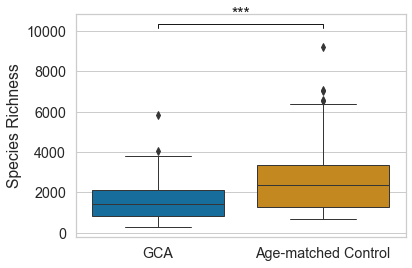

In [31]:
# Plots
sns.set_theme(style="whitegrid", palette="colorblind", font_scale=1.3)
fig, ax1 = plt.subplots(1, 1, sharex=True, sharey=False)
y_axis = 'Species R.'
splot1 = sns.boxplot(x=data['Label'],y=data[y_axis], width=0.8, linewidth = 1)
  
ax1.set_ylabel('Species Richness')
ax1.set_xlabel('',fontsize=1)                                                      

# Get the y-axis limits
bottom, top = ax1.get_ylim()
y_range = top - bottom

# Significance bars
if y_axis in significant_combinations.keys():
    # Columns corresponding to the datasets of interest
    x1 = 0
    x2 = 1
    # What level is this bar among the bars above the plot?
    level = 1
    # Plot the bar
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = significant_combinations[y_axis]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize=16)


plt.tight_layout()
plt.savefig(os.path.join(basefolder, plotsfolder,y_axis+'.pdf'))

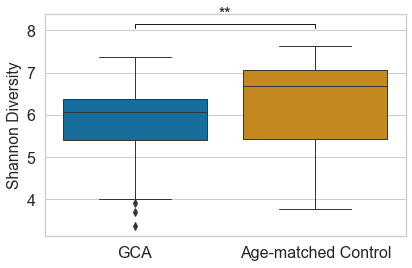

In [32]:
# Plots
sns.set_theme(style="whitegrid", palette="colorblind", font_scale=1.3)
fig, ax1 = plt.subplots(1, 1, sharex=True, sharey=False)
y_axis = 'Shannon'
splot1 = sns.boxplot(x=data['Label'],y=data[y_axis], width=0.8, linewidth = 1)
  
ax1.set_ylabel('Shannon Diversity')
ax1.set_xlabel('',fontsize=1)
ax1.tick_params(labelsize=16)                                                        

# Get the y-axis limits
bottom, top = ax1.get_ylim()
y_range = top - bottom

# Significance bars
if y_axis in significant_combinations.keys():
    # Columns corresponding to the datasets of interest
    x1 = 0
    x2 = 1
    # What level is this bar among the bars above the plot?
    level = 1
    # Plot the bar
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = significant_combinations[y_axis]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize=16)


plt.tight_layout()
plt.savefig(os.path.join(basefolder, plotsfolder,y_axis+'.pdf'))

In [ ]:
def heatmap(x, y, size, color):
    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x15 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the leftmost 14 columns of the grid for the main plot
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
    color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
        ind = int(val_position * (n_colors - 1)) # target index in the color palette
        return palette[ind]

    ax.scatter(
        x=x.map(x_to_num),
        y=y.map(y_to_num),
        s=size * size_scale,
        c=color.apply(value_to_color), # Vector of square color values, mapped to color palette
        marker='s'
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right', size=16)
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels, size=16)
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])

    # Colorbar
    # Add color legend on the right side of the plot
    ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

    col_x = [0]*len(palette) # Fixed x coordinate for the bars
    bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

    bar_height = bar_y[1] - bar_y[0]
    ax.barh(
        y=bar_y,
        width=[5]*len(palette), # Make bars 5 units wide
        left=col_x, # Make bars start at 0
        height=bar_height,
        color=palette,
        linewidth=0
    )
    ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
    ax.grid(False) # Hide grid
    ax.set_facecolor('white') # Make background white
    ax.set_xticks([]) # Remove horizontal ticks
    ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
    ax.yaxis.tick_right() # Show vertical ticks on the right 


/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  del sys.path[0]


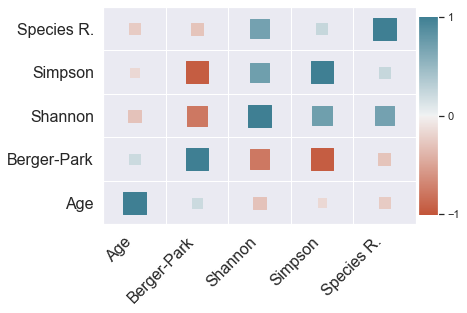

In [ ]:
sns.set_theme()
columns = ['Age','Species R.', 'Shannon','Simpson', 'Berger-Park']
corr = data[columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']

heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color=corr['value']
)
plt.tight_layout()
plt.savefig(os.path.join(basefolder, plotsfolder,'correlation_diversities_age.pdf'),bbox_inches='tight')